# Particle Swarm Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def objectiveFunction(location):
    return (location[0]-15)**2 + (location[1]-20)**2
def assessFitness(location):
    return 1/objectiveFunction(location) # minimization so we change it to 1/score

class Particle:
    def __init__(self, location, velocity):
        self.location = location
        self.velocity = velocity
        self.initialize()
        

    def __init__(self, dimension_x_min, dimension_x_max, dimension_y_min, dimension_y_max):
        #Just put a random point within the bounds of the search space
        self.location = [np.random.uniform(dimension_x_min,dimension_x_max),np.random.uniform(dimension_y_min,dimension_y_max)]
        #Just select two points at random and use half of their distance as the velocity
        random_pointA = [np.random.uniform(dimension_x_min,dimension_x_max),np.random.uniform(dimension_y_min,dimension_y_max)]
        random_pointB = [np.random.uniform(dimension_x_min,dimension_x_max),np.random.uniform(dimension_y_min,dimension_y_max)]
        self.velocity = [(random_pointA[0]-random_pointB[0]/2),(random_pointA[1]-random_pointB[1]/2)]
        self.initialize()
        
    def initialize(self):
        self.bestLocation = []
        self.bestLocationScore = 0
        self.bestLocationInformatants = []
        self.bestLocationScoreInformatants = 0
        self.bestLocationGlobal = []
        self.bestLocationScoreGlobal = 0
        self.currentScore = 0
    
    def getLocation(self):
        return self.location
    def getScore(self):
        return self.currentScore
    def getVelocity(self):
        return self.velocity
    def getSelfBestScore(self):
        return self.bestLocationScore
    def getSelfBestLocation(self):
        return self.bestLocation
    def getInformantBestLocation(self):
        return self.bestLocationInformants
    
    #Update position, score, and velocity
    def update(self, velocity):
        self.location = [sum(x) for x in zip(self.location, velocity)]
        self.velocity = velocity

    def updateScore(self, score):
        #new iteration, so we (optionally) delete the old information of the informants, since we sochastically select new informants
        self.bestLocationInformants = []
        self.bestLocationScoreInformants = 0
        self.currentScore = score
        if len(self.bestLocation) == 0 or self.bestLocationScore < score:
            self.bestLocation = self.location
            self.bestLocationScore = score
    
    def updateInformant(self, informant):
        if len(self.bestLocationInformants) == 0 or self.bestLocationScoreInformants < informant.getSelfBestScore():
            self.bestLocationScoreInformants = informant.getSelfBestScore()
            self.bestLocationInformants = informant.getLocation()
    
    def updateGlobalBest(self, bestLocation, bestLocationScore):
        if len(self.bestLocationGlobal) == 0 or self.bestLocationScoreGlobal < bestLocationScore:
            self.bestLocationScoreGlobal = bestLocationScore
            self.bestLocationGlobal = bestLocation
            
    def printStatistic(self):
        print("Current location: ", self.location)
        print("Current score: ", self.currentScore)
        print("Current velocity: ", self.velocity)
        print("Current best score: ", self.bestLocationScore)
        

In [2]:
import random
def particleSwarmOptimization(swarmsize, alpha=0.8, beta=0.5, gamma=0.5, delta=0.1, epsilon=1, fractionOfInformants=0.1, initial_particles = []):
    min_x = 0
    max_x = 30
    min_y = 0
    max_y = 30
    history = [] #to visualize the movement of the particles
    
    #initialize the first particles
    particles = initial_particles
    if swarmsize > len(initial_particles):
        for i in range(swarmsize-len(initial_particles)):
            particles.append(Particle(min_x,max_x,min_y,max_y))
    bestLocation = []
    bestLocationScore = 0
    numberOfInformants = max(int(swarmsize*fractionOfInformants),1)
    abort = False
    iterations = 50
    while abort != True:
        history.append([x.getLocation() for x in particles])
        for particle in particles:
            fitness = assessFitness(particle.getLocation())
            particle.updateScore(fitness)
            if len(bestLocation) == 0 or bestLocationScore < fitness:
                bestLocation = particle.getLocation()
                bestLocationScore = fitness
        
        #Update the informants scores of each particle and the global best score
        for particle in particles:
            for i in range(numberOfInformants):
                # Prevent that we use ourself as an informant
                while True:
                    informantIndex = random.randint(0,swarmsize-1)
                    if i != informantIndex:
                        particle.updateInformant(particles[informantIndex])
                        break
            particle.updateGlobalBest(bestLocation, bestLocationScore)
            new_velocity = []
            old_velocity = particle.getVelocity()
            old_location = particle.getLocation()
            for i in range(len(old_location)):#for each dimension of the particle
                b = np.random.uniform(0,beta)
                c = np.random.uniform(0,gamma)
                d = np.random.uniform(0,delta)
                termA = old_velocity[i]*alpha
                termB = b*(particle.getSelfBestLocation()[i]-old_location[i])
                termC = c*(particle.getInformantBestLocation()[i]-old_location[i])
                termD = d*(bestLocation[i]-old_location[i])
                new_velocity.append(epsilon*(old_velocity[i]*alpha + b*(particle.getSelfBestLocation()[i]-old_location[i]) + 
                                   c*(particle.getInformantBestLocation()[i]-old_location[i]) + d*(bestLocation[i]-old_location[i])))
            particle.update(new_velocity)
        iterations = iterations -1
        if iterations <= 0:
            abort = True
    return bestLocation, bestLocationScore, history

In [3]:
loc, score, history = particleSwarmOptimization(4)
print(loc, " ", score)

[15.098018860500845, 19.867512171543346]   36.81787291712245


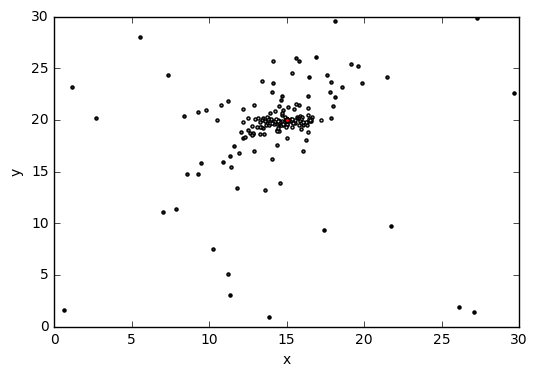

In [4]:
from IPython import display
import time
import matplotlib as mpl
import matplotlib.cm as cm

def plotParticleMovement(ax, particles, iteration):
    x, y = zip(*particles)
    cm = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=0, vmax=50)
    if ax.lines:
        #ax.lines[1]
        ax.lines[1].set_xdata(x)
        #y = [black_box1D(solution)]
        ax.lines[1].set_ydata(y)
        #ax.lines[2].set_xdata(best)
        #y = [black_box1D(best)]
        #ax.lines[2].set_ydata(y)
    else:
        x_optimum = 15
        y_optimum = 20
        print(norm(iteration))
        ax.scatter(x_optimum, y_optimum, s=10, c='r')
        #for particle in particles:
        ax.scatter(x, y, s=5, c=str(norm(iteration)), cmap=cm)
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)


plt.ion()        
fig,ax = plt.subplots(1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 30)
plt.ylim(0, 30)
#plt.colorbar()
#plt.title('1-D ground truth with markers showing the path of simulated annealing')
i = 0
for particles in history:
    plotParticleMovement(ax, particles, i)
    time.sleep(0.2)
    i = i + 1